In [45]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

In [46]:
covid_data = pd.read_csv("United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv", 
                         index_col="submission_date", parse_dates=True)
covid_clean_data = covid_data[["tot_cases","tot_death"]]
covid_really_clean = covid_clean_data.groupby(covid_clean_data.index).sum()
covid_clean_data = covid_data[["tot_cases","tot_death"]]
covid_really_clean = covid_clean_data.groupby(covid_clean_data.index).sum()


In [59]:
covid_arima = covid_really_clean[["tot_death"]]
covid_arima


,tot_death
submission_date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-10-29,228100
2020-10-30,229109
2020-10-31,229978


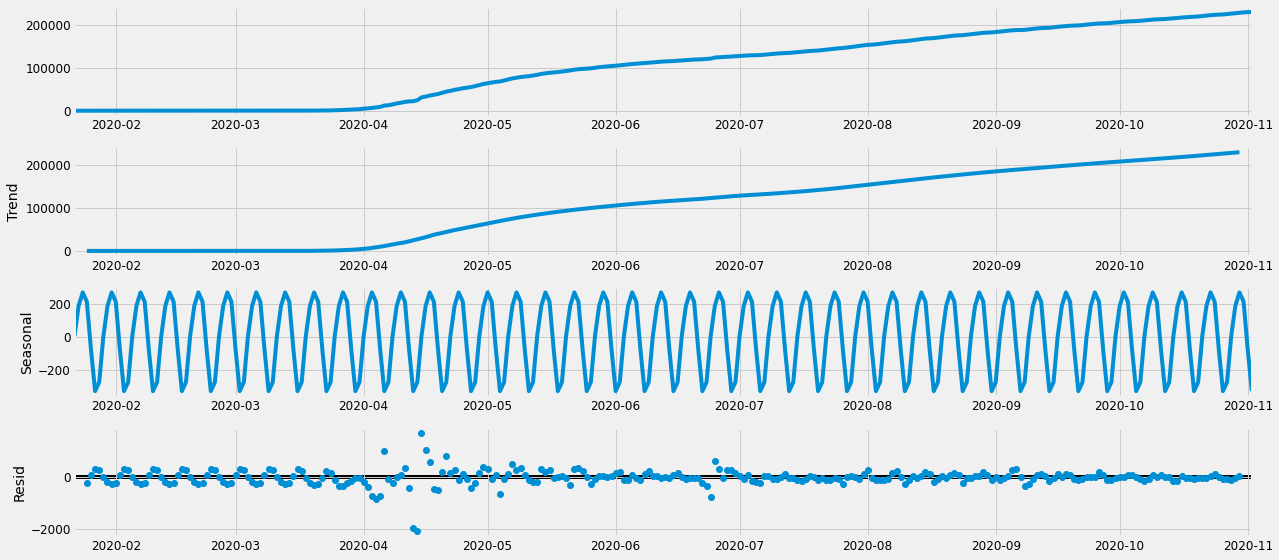

In [48]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(covid_arima, model='additive')
fig = decomposition.plot()
plt.show()

In [49]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [50]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(covid_arima,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7527.677672586456
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:7037.732360181557
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:5914.147344177086
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:5510.76968879724
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:5758.359739270878
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:5585.422134318744
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:5162.1947660044925
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:5089.384237425796
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:7292.892775891358
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6937.626708137928
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:5694.00898299027
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:5404.438257062531
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:6970.423875296306
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:6921.408620629647
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:5429.93331331931
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:4777.183306203329
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:4778.39951970514
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4451.5330397184125
ARIMA(0, 1, 

In [55]:
mod = sm.tsa.statespace.SARIMAX(covid_arima,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9798      0.012     82.341      0.000       0.956       1.003
ma.L1         -0.7402      0.042    -17.653      0.000      -0.822      -0.658
ar.S.L12      -0.1224      0.061     -2.016      0.044      -0.241      -0.003
ma.S.L12      -1.0000      0.031    -31.804      0.000      -1.062      -0.938
sigma2      2.302e+05   1.37e-07   1.68e+12      0.000     2.3e+05     2.3e+05


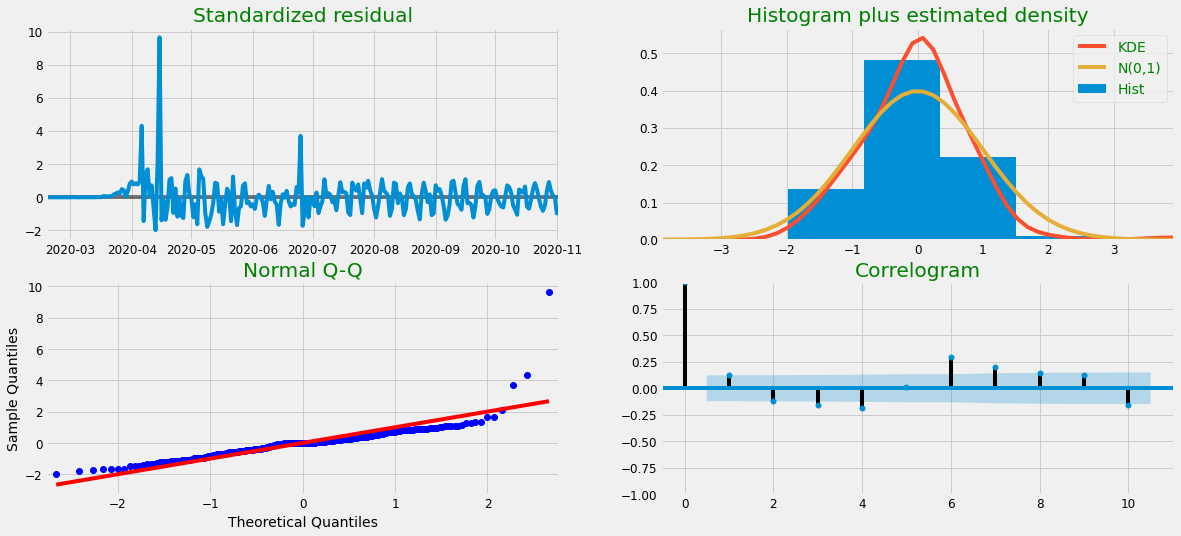

In [56]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

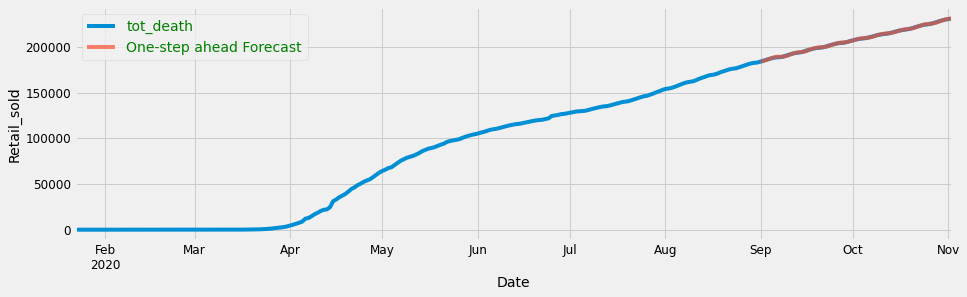

In [67]:
pred = results.get_prediction(start=pd.to_datetime('09/01/2020'), dynamic=False)
pred_ci = pred.conf_int()
ax = covid_arima['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

In [70]:
covid_arima_forecasted = pred.predicted_mean
covid_arima_truth = covid_arima['09/01/2020':]
mse = ((covid_arima_forecasted - covid_arima_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 2020-09-01 00:00:00   NaN
2020-09-02 00:00:00   NaN
2020-09-03 00:00:00   NaN
2020-09-04 00:00:00   NaN
2020-09-05 00:00:00   NaN
                       ..
2020-10-30 00:00:00   NaN
2020-10-31 00:00:00   NaN
2020-11-01 00:00:00   NaN
2020-11-02 00:00:00   NaN
tot_death             NaN
Length: 64, dtype: float64
The Root Mean Squared Error is 2020-09-01 00:00:00   NaN
2020-09-02 00:00:00   NaN
2020-09-03 00:00:00   NaN
2020-09-04 00:00:00   NaN
2020-09-05 00:00:00   NaN
                       ..
2020-10-30 00:00:00   NaN
2020-10-31 00:00:00   NaN
2020-11-01 00:00:00   NaN
2020-11-02 00:00:00   NaN
tot_death             NaN
Length: 64, dtype: float64


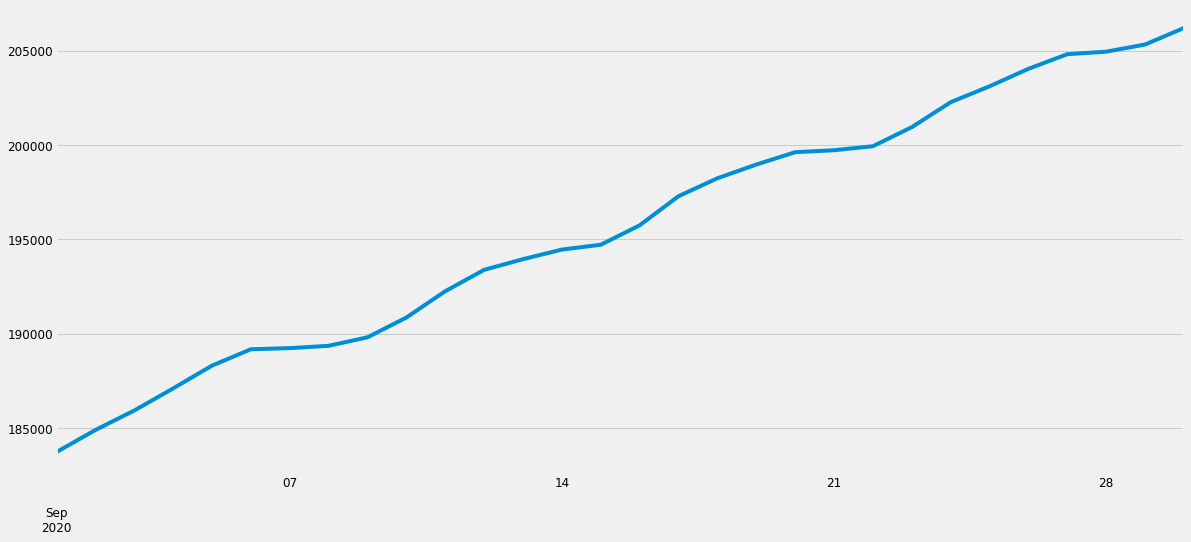

In [75]:
covid_arima_forecasted = pred.predicted_mean
covid_arima_forecasted.head(30).plot()

In [76]:
covid_arima_forecasted.head(30)

2020-09-01    183725.328385
2020-09-02    184894.251873
2020-09-03    185928.361676
2020-09-04    187100.161031
2020-09-05    188307.716313
2020-09-06    189177.308452
2020-09-07    189237.325305
2020-09-08    189360.367955
2020-09-09    189810.234568
2020-09-10    190859.159364
2020-09-11    192254.173190
2020-09-12    193387.041282
2020-09-13    193953.568636
2020-09-14    194461.984888
2020-09-15    194717.700756
2020-09-16    195747.358739
2020-09-17    197291.920803
2020-09-18    198241.667363
2020-09-19    198969.559267
2020-09-20    199624.606094
2020-09-21    199728.240735
2020-09-22    199941.171061
2020-09-23    200952.007291
2020-09-24    202274.724152
2020-09-25    203118.103956
2020-09-26    204045.356525
2020-09-27    204821.220889
2020-09-28    204953.226083
2020-09-29    205332.511560
2020-09-30    206211.254049
Freq: D, dtype: float64